In [1]:
%matplotlib inline

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from pathlib import Path

import tensorflow as tf

from tensorflow.io import read_file
from tensorflow.image import decode_jpeg, resize
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, \
    BatchNormalization, Flatten, Add, Embedding, LSTM, GlobalAvgPool2D, Concatenate, Conv2DTranspose

# Image Classification Exam Prep

1. Create map-style dataset.
    - Create records `(filepath, class)`. The `filepath` is in a way a proxy to the data.
    - Read records using `tf.data.Dataset.from_tensor_slices()`.
1. Preprocess images.
    - Create function that preprocesses a single image.
        - read the bytes in the file
        - decode the raw bytes using jpg encoding
    - Apply the function: `dataset.map(func)`.
1. Reformat the labels to be numbers.
1. Include a resize step in the preprocessing. Every image shall have the same size.
1. Add shuffling (as early as possible).
1. Set random seeds.
1. Add mini-batches.
1. Add `repeat`.
1. Chain the steps (instead of assignment to the same variable).
1. Add scaling in the image preprocess func.
1. Implement methods of splitting to val, train, test:
    1. Save filepaths to external txt file.
        - Create `df.data.Dataset`, shuffle it, and save the output to a helper text file.
        - It can be read  instead of the raw filepaths.
    1. Use `sklearn`'s `train_test_split`.

## Constants

In [3]:
IMAGE_SHAPE = (100, 100)
IMAGE_SHAPE_WITH_CHANNELS = (100, 100, 3)
BATCH_SIZE = 8
SEQUENCE_LEN = 10
VOCABULARY_SIZE = 14000
EMBEDDING_OUTPUT_DIMENSION = 32

dataset_path = Path().home() / 'Desktop' / 'datasets' / 'natural_images'

## Set random seeds

In [4]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data preparation

### Load data

In [5]:
unique_labels = [item.name for item in dataset_path.glob('*')]
number_to_label = dict(enumerate(unique_labels))
label_to_number = {v: k for k, v in number_to_label.items()}
label_to_number

{'airplane': 0,
 'car': 1,
 'cat': 2,
 'dog': 3,
 'flower': 4,
 'fruit': 5,
 'motorbike': 6,
 'person': 7}

In [6]:
filepaths = []
labels = []

for p in dataset_path.glob('*/*.jpg'):
    filepath = p.as_posix()
    label = label_to_number.get(p.parent.name)
    filepaths.append(filepath)
    labels.append(label)

filepaths[0], labels[0]

('C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0000.jpg',
 0)

In [7]:
dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
first_record = [_ for _ in dataset.take(1)]
first_record

[(<tf.Tensor: shape=(), dtype=string, numpy=b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0000.jpg'>,
  <tf.Tensor: shape=(), dtype=int32, numpy=0>)]

### Preprocess images

In [8]:
def preprocess_image(filepath, label):
    image_bytes = read_file(filepath)
    image = decode_jpeg(image_bytes)

    image = resize(image, IMAGE_SHAPE)
    image = image / 256

    return image, label

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
dataset = dataset.shuffle(buffer_size=len(dataset))
dataset = dataset.map(preprocess_image)

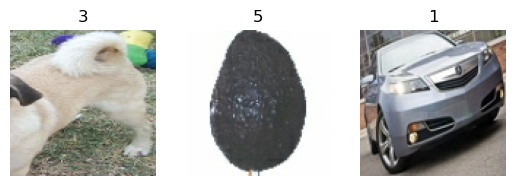

In [10]:
# Display the first `n` images after preprocessing and shuffling
i = 1
n_images = 3
for image_tensor, label_tensor in dataset.take(n_images):
    plt.subplot(1, n_images, i)
    plt.imshow(image_tensor.numpy())
    plt.title(label_tensor.numpy())
    plt.axis('off')
    i += 1

plt.show()

### Split into batches

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
dataset = dataset.shuffle(buffer_size=len(dataset), seed=SEED)
dataset = dataset.map(preprocess_image)
dataset = dataset.batch(batch_size=BATCH_SIZE)  # new

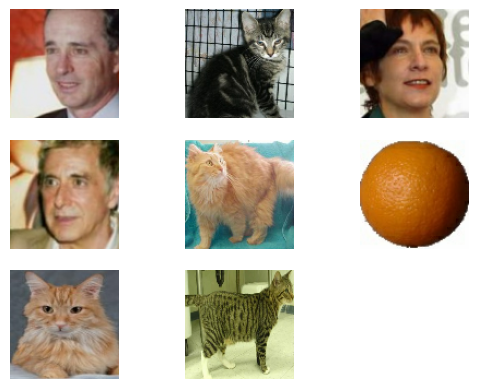

In [12]:
# Display the first minibatch
n_rows = 3
n_cols = np.ceil(BATCH_SIZE / n_rows).astype('int')

for minibatch in dataset.take(1):
    images = minibatch[0].numpy()
    for i, image in enumerate(images):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()

### Add `repeat`

In [13]:
# Add `repeat`. Chain the steps.

dataset = (
    tf.data.Dataset.from_tensor_slices((filepaths, labels))
    .shuffle(buffer_size=len(dataset), seed=SEED)
    .map(preprocess_image)
    .batch(batch_size=BATCH_SIZE)
    .repeat()
)

dataset

<RepeatDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Split data

In [14]:
# One method of splitting the data to train, val, and test sets

a_split = filepaths[:10]

list(tf.data.Dataset.from_tensor_slices(a_split)
     .shuffle(len(a_split))
     .as_numpy_iterator()
     )

# save split to text files and read instead of reading the filepaths names each time

[b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0003.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0008.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0000.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0009.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0001.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0006.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0007.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0005.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0002.jpg',
 b'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0004.jpg']

In [15]:
# Second method of splitting the data

from sklearn.model_selection import train_test_split

# First split to create [train+val] and test
train_test_split(filepaths[:10], stratify=labels[:10], test_size=0.3)

# Second, to create val and train
# train_test_split(...)

[['C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0001.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0004.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0002.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0006.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0009.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0000.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0003.jpg'],
 ['C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0005.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0007.jpg',
  'C:/Users/a1056968/Desktop/datasets/natural_images/airplane/airplane_0008.jpg']]

### Add `prefetch`

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
dataset = (dataset
           .shuffle(buffer_size=len(dataset), seed=SEED)
           .map(preprocess_image)
           .batch(batch_size=BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE)
           .repeat()
           )

dataset

<RepeatDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Model data

### First try

In [17]:
input_layer = Input(shape=IMAGE_SHAPE_WITH_CHANNELS)
conv_layer1 = Conv2D(filters=32, kernel_size=(
    3, 3), padding='same', activation='relu')(input_layer)
conv_layer2 = Conv2D(filters=32, kernel_size=(
    3, 3), padding='same', activation='relu')(conv_layer1)
max_pool = MaxPool2D()(conv_layer2)

In [18]:
cnn = Model(inputs=input_layer, outputs=max_pool)
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
Total params: 10,144
Trainable params: 10,144
Non-trainable params: 0
_________________________________________________________________


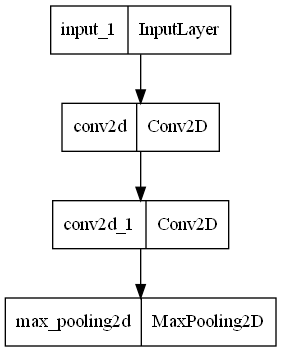

In [19]:
tf.keras.utils.plot_model(cnn)

### Conv block

In [20]:
def conv_block(input_layer, filters=32, kernel_size=(3, 3)):
    x = Conv2D(filters=filters, kernel_size=kernel_size,
               padding='same', activation='relu')(input_layer)
    x = Conv2D(filters=filters, kernel_size=kernel_size,
               padding='same', activation='relu')(x)
    x = MaxPool2D()(x)

    return x


input_layer = Input(shape=IMAGE_SHAPE_WITH_CHANNELS)
conv_block(input_layer)

<KerasTensor: shape=(None, 50, 50, 32) dtype=float32 (created by layer 'max_pooling2d_1')>

### Multiple conv blocks

In [21]:
input_layer = Input(shape=IMAGE_SHAPE_WITH_CHANNELS)
conv_block1 = conv_block(input_layer)
conv_block2 = conv_block(conv_block1)
conv_block3 = conv_block(conv_block2)

In [22]:
Model(inputs=input_layer, outputs=conv_block3).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 32)        9248      
                                                           

### Custom layer names

In [23]:
def conv_pooling_block(input_layer, filters=32, kernel_size=(3, 3), name=''):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same',
               activation='relu', name=name+'Conv2D_1')(input_layer)
    x = Conv2D(filters=filters, kernel_size=kernel_size,
               padding='same', activation='relu', name=name+'Conv2D_2')(x)
    x = MaxPool2D(name=name+'MaxPool2D')(x)

    return x


input_layer = Input(shape=IMAGE_SHAPE_WITH_CHANNELS)
conv_pooling_block(input_layer)

<KerasTensor: shape=(None, 50, 50, 32) dtype=float32 (created by layer 'MaxPool2D')>

In [24]:
input_layer = Input(shape=IMAGE_SHAPE_WITH_CHANNELS)
conv_block1 = conv_pooling_block(input_layer, name='block1_')
conv_block2 = conv_pooling_block(conv_block1, name='block2_')
conv_block3 = conv_pooling_block(conv_block2, name='block3_')
flatten_layer = Flatten()(conv_block3)
output_layer = Dense(10, activation='softmax')(flatten_layer)

Model(inputs=input_layer, outputs=output_layer).summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_Conv2D_1 (Conv2D)    (None, 100, 100, 32)      896       
                                                                 
 block1_Conv2D_2 (Conv2D)    (None, 100, 100, 32)      9248      
                                                                 
 block1_MaxPool2D (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 block2_Conv2D_1 (Conv2D)    (None, 50, 50, 32)        9248      
                                                                 
 block2_Conv2D_2 (Conv2D)    (None, 50, 50, 32)        9248      
                                                           

### Adding normalization of the batches

In [25]:
def conv_pooling_block(input_layer, filters=32, kernel_size=(3, 3), name=''):
    x = BatchNormalization()(input_layer)
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same',
               activation='relu', name=name+'Conv2D_1')(input_layer)
    x = Conv2D(filters=filters, kernel_size=kernel_size,
               padding='same', activation='relu', name=name+'Conv2D_2')(x)
    x = MaxPool2D(name=name+'MaxPool2D')(x)

    return x


input_layer = Input(shape=IMAGE_SHAPE_WITH_CHANNELS)
conv_pooling_block(input_layer)

<KerasTensor: shape=(None, 50, 50, 32) dtype=float32 (created by layer 'MaxPool2D')>

### Residual block

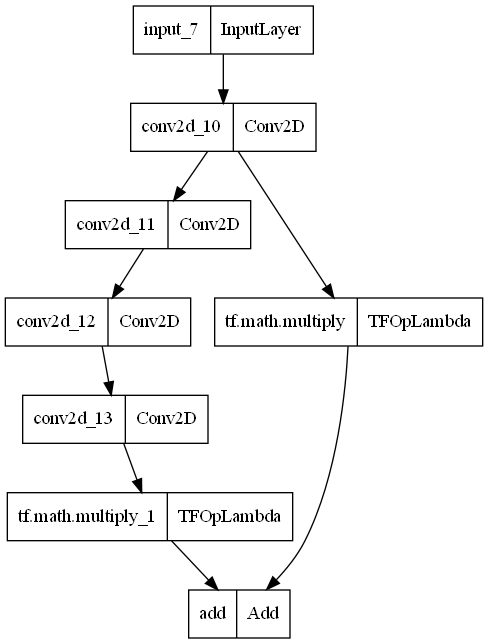

In [26]:
input_layer = Input(shape=IMAGE_SHAPE_WITH_CHANNELS)
input_conv = Conv2D(filters=16, kernel_size=(3, 3))(input_layer)

conv_layer1 = Conv2D(filters=16, kernel_size=(
    3, 3), padding='same', activation='relu')(input_conv)
conv_layer2 = Conv2D(filters=16, kernel_size=(
    3, 3), padding='same', activation='relu')(conv_layer1)
conv_layer3 = Conv2D(filters=16, kernel_size=(
    3, 3), padding='same', activation='relu')(conv_layer2)

alpha, beta = 0.5, 0.5
residual_layer = Add()([alpha*input_conv, beta*conv_layer3])

residual_model = Model(inputs=input_layer, outputs=residual_layer)

tf.keras.utils.plot_model(residual_model)

## Model two data modalities (heterogeneous model)

### Generate dummy data

In [27]:
dummy_image_data = np.random.randn(BATCH_SIZE, *IMAGE_SHAPE_WITH_CHANNELS)
dummy_image_data.shape

(8, 100, 100, 3)

In [28]:
def generate_dummy_texts(batch_size=32, vocab_size=10_000, sequence_len=10):
    sequence_lenghts = np.random.randint(
        1, sequence_len + 1, size=(batch_size,))

    texts = []
    for l in sequence_lenghts:
        sentence = np.random.randint(0, vocab_size, size=(l,))
        padding_after = sequence_len - l
        sentence_padded = np.pad(sentence, pad_width=(0, padding_after))
        texts.append(sentence_padded)

    return texts


generate_dummy_texts(batch_size=BATCH_SIZE,
                     vocab_size=VOCABULARY_SIZE, sequence_len=SEQUENCE_LEN)

[array([7635,  353, 9549, 4557, 2003, 6528, 1442, 7093,  925,  650]),
 array([3022, 2585, 1764,  132, 1199, 7238, 5398,    0,    0,    0]),
 array([12894,  2853, 12209,  2615,  5159,  5020, 12411,  3662,  1639,
        13621]),
 array([10141,  3704,  4601,  6581,     0,     0,     0,     0,     0,
            0]),
 array([ 6072, 13107,  6830,  4245,  7397, 10074,     0,     0,     0,
            0]),
 array([  574, 10995,  6027,  8926,  5172,  6534,  5631,  4094, 10145,
            0]),
 array([8280,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([ 1453, 12439,  2716,  3743,  9070,  5979,  7993,  3525, 10220,
            0])]

### Create model cores

In [29]:
image_core = Sequential([
    Input(shape=IMAGE_SHAPE_WITH_CHANNELS),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPool2D(),
    Conv2D(16, (3, 3), padding='same', activation='relu'),
    MaxPool2D(),
    Conv2D(16, (3, 3), padding='same', activation='relu'),
    MaxPool2D(),
])

In [30]:
text_core = Sequential([
    Input(shape=(SEQUENCE_LEN,)),
    Embedding(input_dim=VOCABULARY_SIZE,
              output_dim=EMBEDDING_OUTPUT_DIMENSION),
    LSTM(units=8, return_sequences=True),
    LSTM(units=4, return_sequences=True),
])

In [31]:
print(
    'Output shapes for the image and text core models:',
    image_core.output_shape,
    text_core.output_shape,
    sep='\n'
)

Output shapes for the image and text core models:
(None, 12, 12, 16)
(None, 10, 4)


### Concatenate outputs

In [32]:
image_pooled = GlobalAvgPool2D()(image_core.output)
image_pooled

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'global_average_pooling2d')>

In [33]:
text_flattened = Flatten()(text_core.output)
text_flattened

<KerasTensor: shape=(None, 40) dtype=float32 (created by layer 'flatten_1')>

In [34]:
# Ensure the outputs are vectors (1D).
print('Final shapes: ', image_pooled.shape, text_flattened.shape)

Final shapes:  (None, 16) (None, 40)


In [35]:
concat = Concatenate()([image_pooled, text_flattened])
concat

<KerasTensor: shape=(None, 56) dtype=float32 (created by layer 'concatenate')>

### Final layers and model

In [36]:
dense1 = Dense(10, activation='relu')(concat)
dense2 = Dense(5, activation='relu')(dense1)
final_output = Dense(12, activation='softmax')(dense2)

In [37]:
heterogeneous_model = Model(inputs=[image_core.input, text_core.input], outputs=[final_output,])

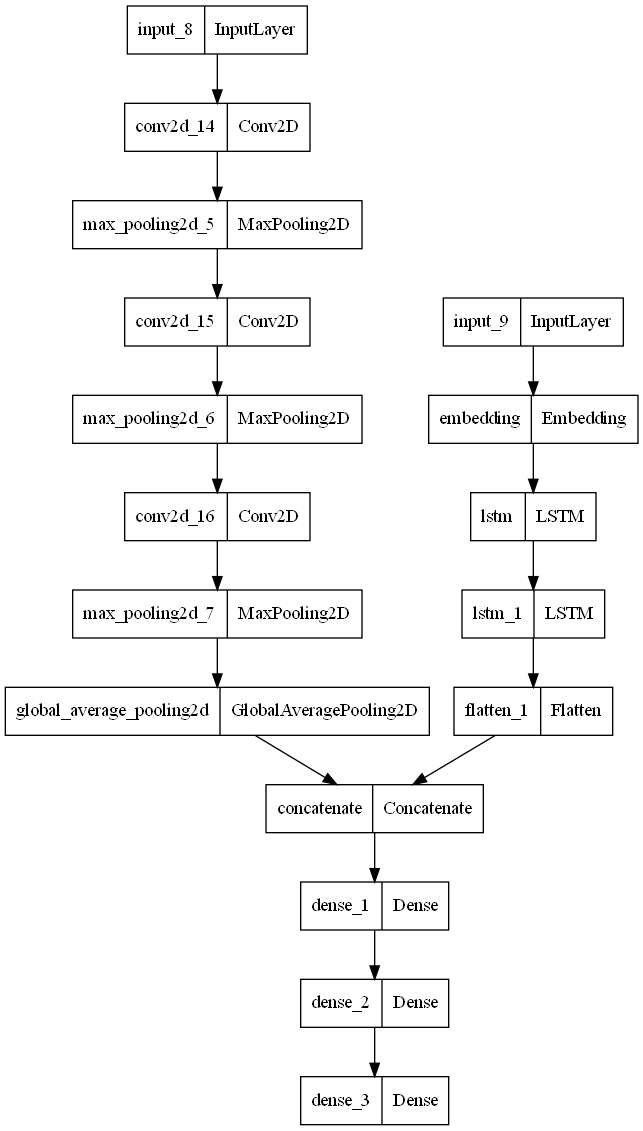

In [38]:
tf.keras.utils.plot_model(heterogeneous_model)

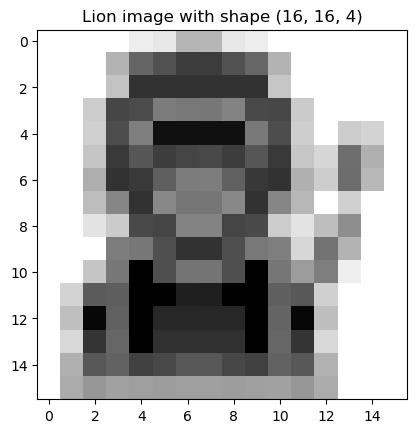

In [51]:
image_path = "../lion.png"
lion = plt.imread(image_path)
lion_bw = lion[:,:, 0]

plt.imshow(lion_bw, cmap='gray_r')
plt.title(f'Lion image with shape {lion.shape}')
plt.show()

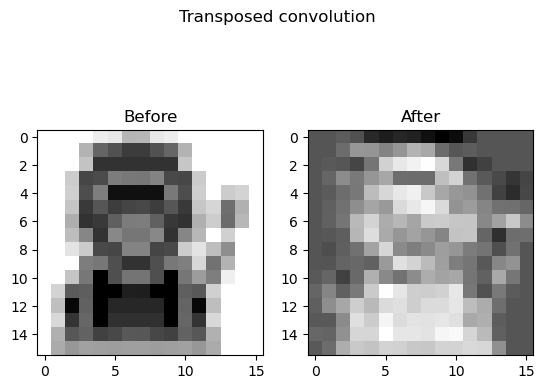

In [68]:
# Expand dimensions.
lion_in_batch = lion_bw[np.newaxis,:,:, np.newaxis]
lion_in_batch.shape

# Cretae trasnposed conv and apply it over the image.
transposed_convolution = Conv2DTranspose(filters=1, kernel_size=(3, 3), padding='same')
output = transposed_convolution(lion_in_batch).numpy().reshape(16, 16)

plt.subplot(121)
plt.imshow(lion_bw, cmap='gray_r')
plt.title(f'Before')


plt.subplot(122)
plt.imshow(output, cmap='gray_r')
plt.title(f'After')

plt.suptitle('Transposed convolution')
plt.show()